# Healthcare Insurance Charge Prediction

This project focuses on predicting healthcare insurance charges based on personal attributes, lifestyle factors, and geographic information. By analyzing features such as age, gender, body mass index (BMI), family size, and smoking habits, along with regional data, the goal is to identify key drivers of medical insurance costs. Using machine learning models, the aim is to build a predictive system that accurately estimates healthcare expenses, providing insights into how these factors contribute to variations in insurance premiums.

Data source: https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance/data

# Data Cleaning

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [100]:
# Load data
df=pd.read_csv('insurance.csv')
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Features
- **age**: The age of each person.
- **sex**: The gender (female or male) of each individual.
- **bmi**: Body Mass Index (BMI), which is a measure of body fat based on height and weight.
- **children**: The number of children each person has.
- **smoker**: Indicates whether the person smokes (yes for smokers, no for non-smokers).
- **region**: The geographic region where each person resides (southwest, southeast, northwest, or northeast).
- **charges**: The annual medical insurance charges for each person.


### Data Summerization
There are 1338 individual data points, 7 features presented.

4 features are continuous valued: "age", "bmi", "children", "charges"

3 features are categorical: "sex", "smoker", "region"

There is no missing value to be handled.

In [101]:
print(df.info())

# How much data is present?
print("Number of rows and columns:", df.shape)

# Which features are continuous values?
continuous_features = df.select_dtypes(include=np.number).columns.tolist()
print("Continuous features:", continuous_features)

# Which features are categorical?
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:", categorical_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
Number of rows and columns: (1338, 7)
Continuous features: ['age', 'bmi', 'children', 'charges']
Categorical features: ['sex', 'smoker', 'region']


In [102]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Missing Values

There is no missing values in the data.

In [103]:
# Check missing values
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


### Outliers

Draw boxplots to identify outliers.

The **age** distribution is quite uniform with no obvious outliers. There are a few outliers visible in the **BMI** feature, particularly on the higher end. There don’t appear to be any significant outliers in the **number of children**, though the data is right-skewed since the maximum value is 5. Most individuals have 0-2 children.

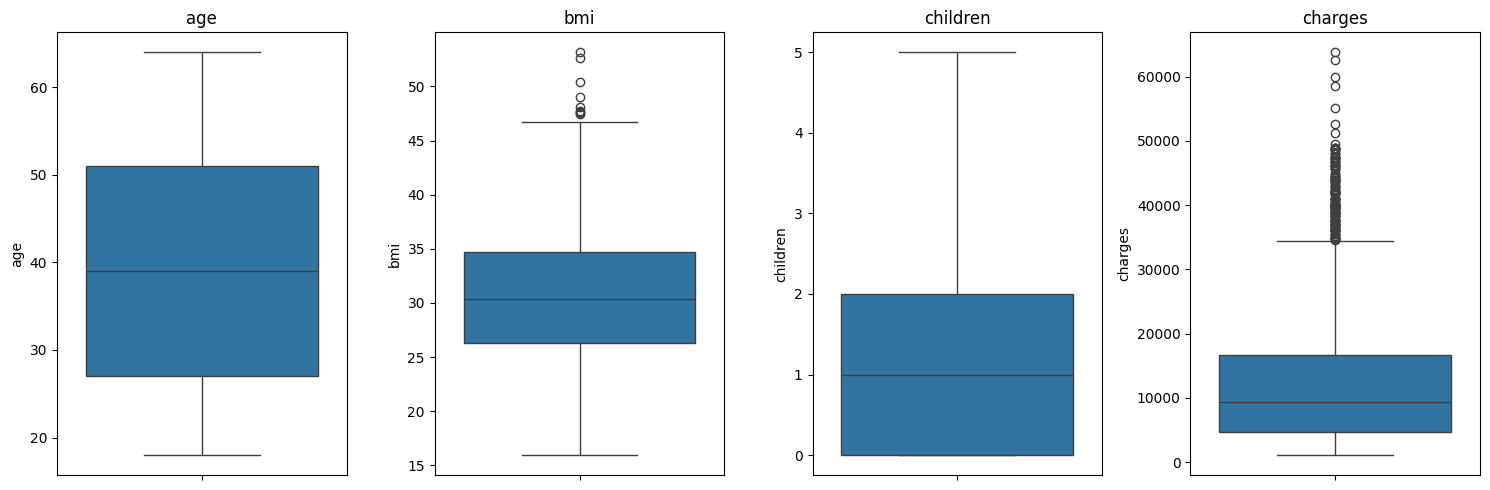

In [104]:
# Boxplots for outlier detection
plt.figure(figsize=(15, 5))
for i, col in enumerate(continuous_features):
  plt.subplot(1, len(continuous_features), i+1)
  sns.boxplot(y=df[col])
  plt.title(col)
plt.tight_layout()
plt.show()


### Data Statistics
**Visualize distribution of continuous attributes and categorical attributes.**

The distribution of age is equal, with more subjects from 20-year-old group, the potential reason is these young people are under their parents' healthcare insurance.

The bmi distribution is bell-shaped, which aligns with that since height and weight of people are normal distributed, the bmi as a result of the product of height and weight, should also be normally distributed. The bmi data showed that the data collection was fair and was not skewed towards certain group of people in terms of bmi value.

Looking at number of children, most of subjects don't have children, this aligns with the age data which showed most of the subjects were about 20 years old teenages.

The distribution of charges is heavily right-skewed, meaning that most individuals have lower healthcare costs, but a few have extremely high charges.

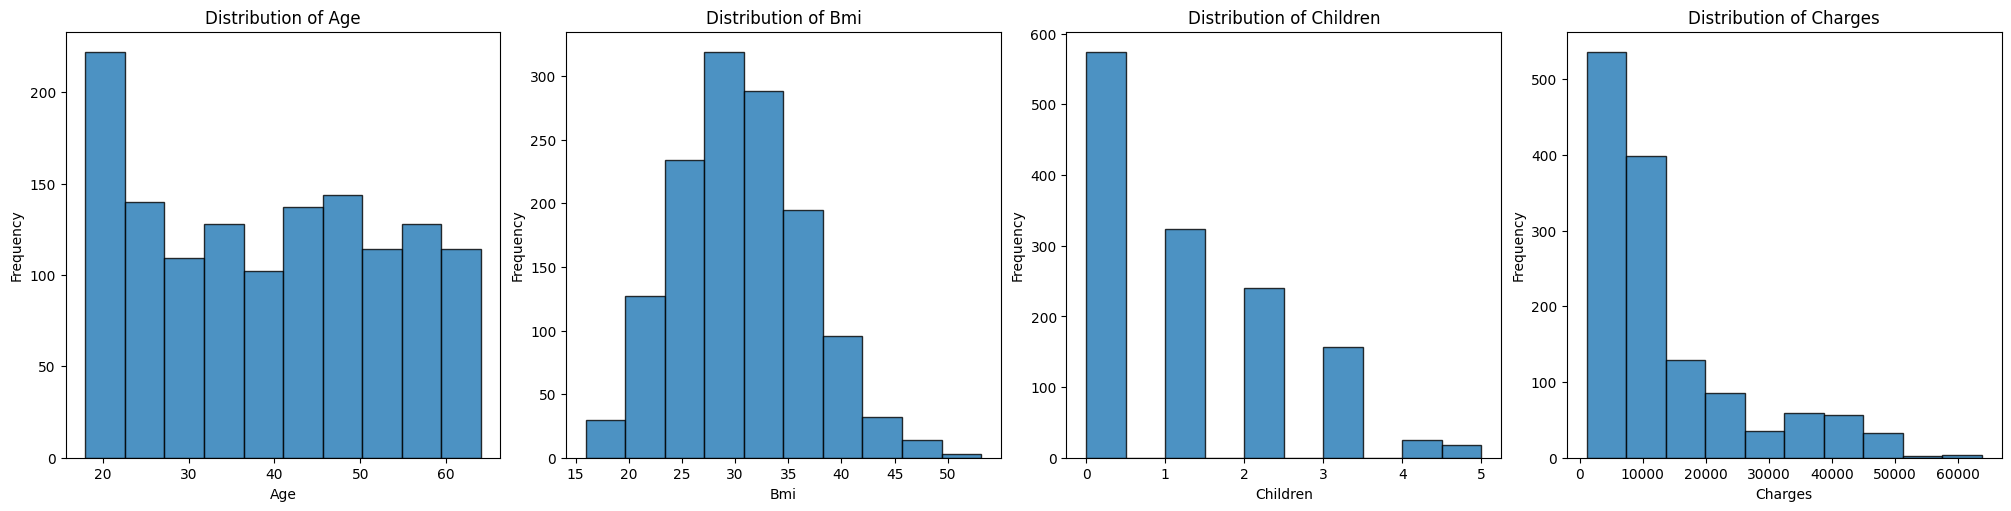

In [105]:
# Features to plot
features = ["age", "bmi", "children", "charges"]
num_features = len(features)

# Set up the figure and axes
fig, axes = plt.subplots(1, num_features, figsize=(20, 5), constrained_layout=True)

# Loop through each feature to create individual histograms in subplots
for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=10, edgecolor='black', alpha=0.8)
    axes[i].set_title(f'Distribution of {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Frequency')

plt.show()


There is a positive correlation between age and charges (0.30). As age increases, charges tend to increase. This is expected, as older individuals typically incur higher medical costs.

There is a positive correlation between bmi and charges (0.20), but not as strong as age.

The number of children doesn’t appear to have a strong relationship with charges (0.07).

<Figure size 700x500 with 0 Axes>

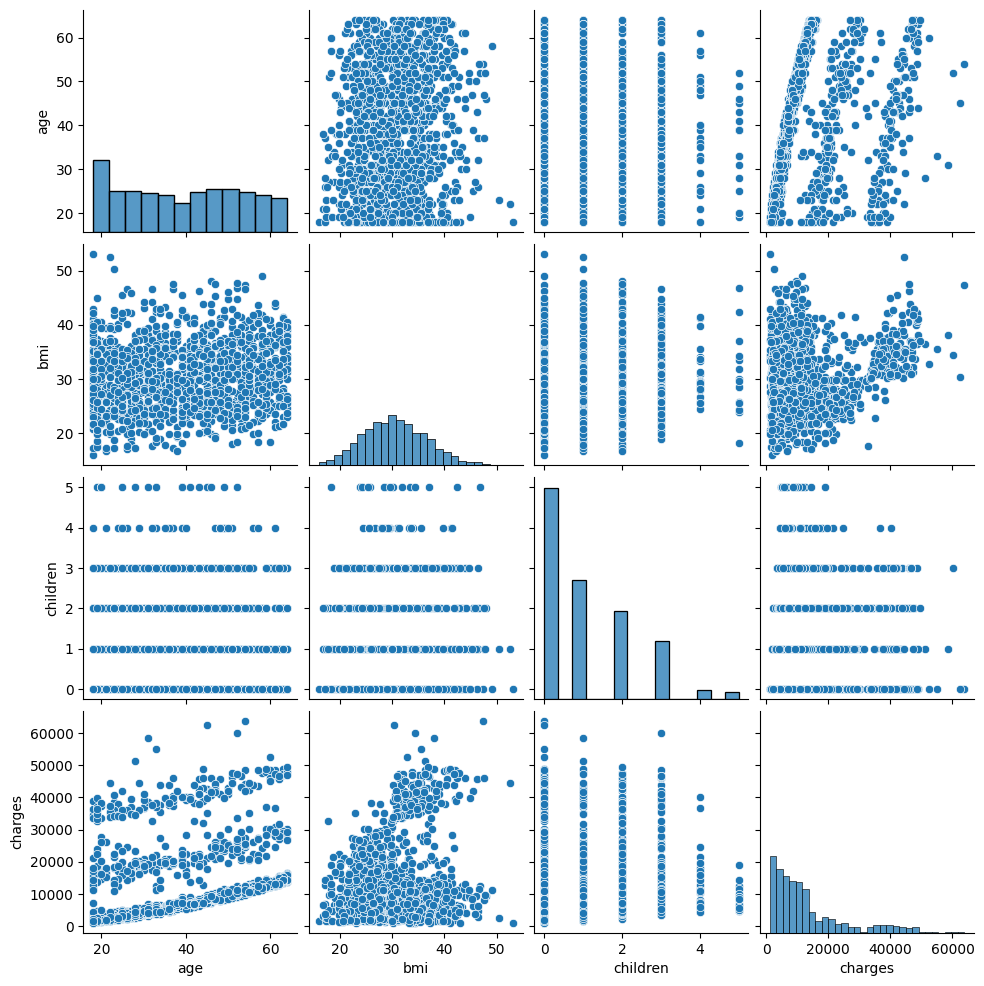

In [106]:
# Correlation analysis
plt.figure(figsize=(7, 5))
sns.pairplot(df[continuous_features])
plt.show()

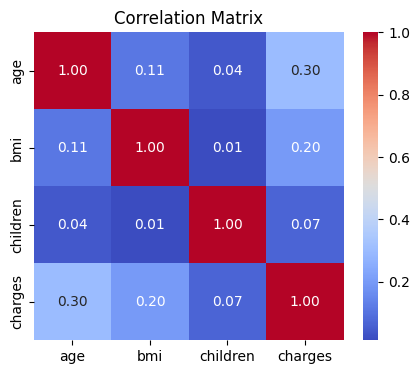

In [107]:
plt.figure(figsize=(5, 4))
correlation_matrix = df[continuous_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [108]:
print(correlation_matrix['charges'].sort_values(ascending=False))

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


**Checking the distribution of categorical features using pie charts**

There are almost equal male and female subjects, less smokers compared to non-smokers, almost equal people from different regions.

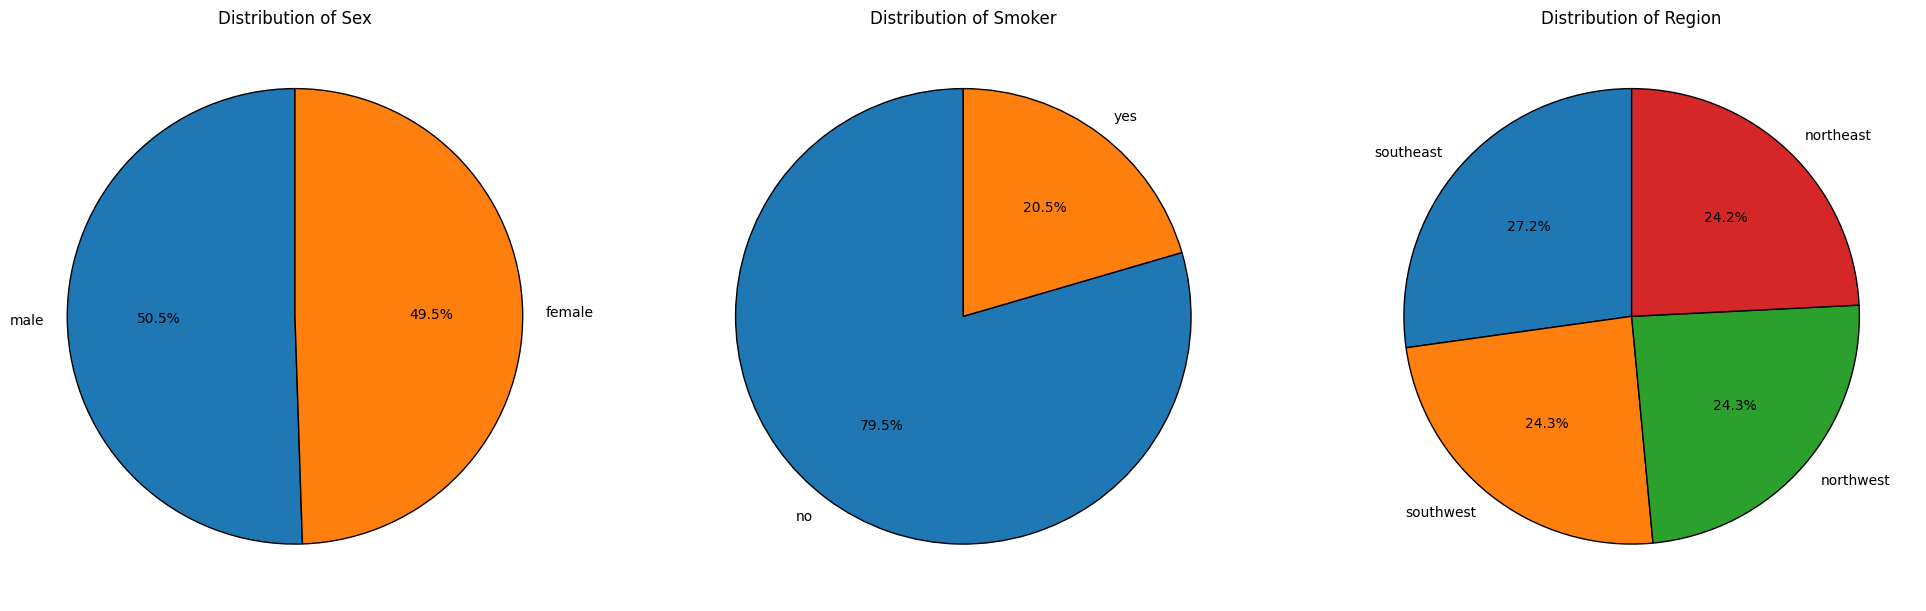

In [109]:
# Categorical features to plot
categorical_features = ["sex", "smoker", "region"]
num_features = len(categorical_features)

# Set up the figure and axes for side-by-side pie charts
fig, axes = plt.subplots(1, num_features, figsize=(20, 6), constrained_layout=True)

# Loop through each feature to create pie charts in subplots
for i, feature in enumerate(categorical_features):
    df[feature].value_counts().plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        shadow=False,
        wedgeprops={'edgecolor': 'black'},
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature.capitalize()}')
    axes[i].set_ylabel('')  # Hide y-axis label for a cleaner look

plt.show()


I plotted Boxplots to look at the impact of smoking on medical charges. Smokers generally have much higher medical charges than non-smokers. From the graph below, the median charge for smokers appears to be around 35,000, while non-smokers have significantly lower charges, with the median charge was only around 7,000-8,000.

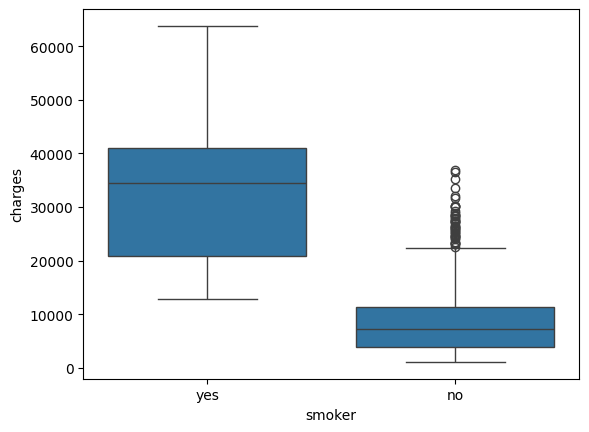

In [110]:
sns.boxplot(x='smoker', y='charges', data=df)
plt.show()

I also looked at how smoking interacts with age. Overall, smokers have higher charges no matter the age is young or old. Charges for non-smokers generally remain much lower, with even older non-smokers having significantly lower charges than younger smokers.

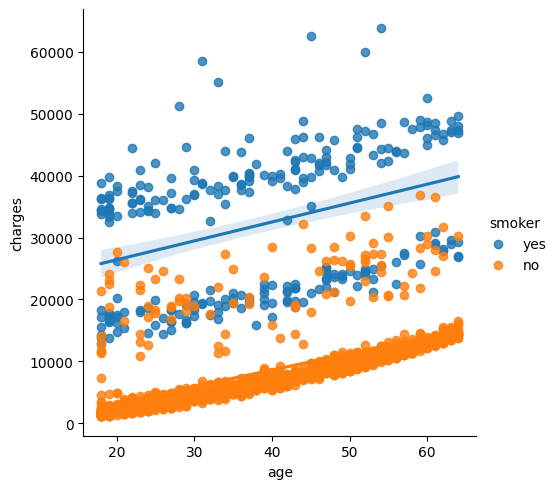

In [111]:
sns.lmplot(x='age', y='charges', hue='smoker', data=df)


### Categorical Attributes Encoding

To better examine the relationship

In [112]:
# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical features
encoded_features = encoder.fit_transform(df[['sex', 'smoker', 'region']])

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['sex', 'smoker', 'region']))

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df.drop(['sex', 'smoker', 'region'], axis=1), encoded_df], axis=1)

# Print the first few rows of the encoded DataFrame
df_encoded.head()


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


# Train-Test Split

In [113]:
# Define features and target variable
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [114]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)


To show test portion is representative, I compared statistics of test data and full data, as well as distribution of age, bmi, and children for both the full dataset and the test dataset.

These graphs showed that the distributions are balanced, and the test data is a good representation of the overall dataset. This suggested that train-test split has not introduced any bias into the data, and the test data is likely to provide a reliable evaluation of your model.

Test Data Summary:
              age         bmi    children  sex_female    sex_male   smoker_no  \
count  335.000000  335.000000  335.000000  335.000000  335.000000  335.000000   
mean    39.062687   31.117343    1.065672    0.492537    0.507463    0.797015   
std     14.102457    6.333625    1.209438    0.500692    0.500692    0.402823   
min     18.000000   16.815000    0.000000    0.000000    0.000000    0.000000   
25%     26.000000   26.505000    0.000000    0.000000    0.000000    1.000000   
50%     39.000000   30.800000    1.000000    0.000000    1.000000    1.000000   
75%     51.000000   35.272500    2.000000    1.000000    1.000000    1.000000   
max     64.000000   52.580000    5.000000    1.000000    1.000000    1.000000   

       smoker_yes  region_northeast  region_northwest  region_southeast  \
count  335.000000        335.000000        335.000000        335.000000   
mean     0.202985          0.217910          0.235821          0.313433   
std      0.402823         

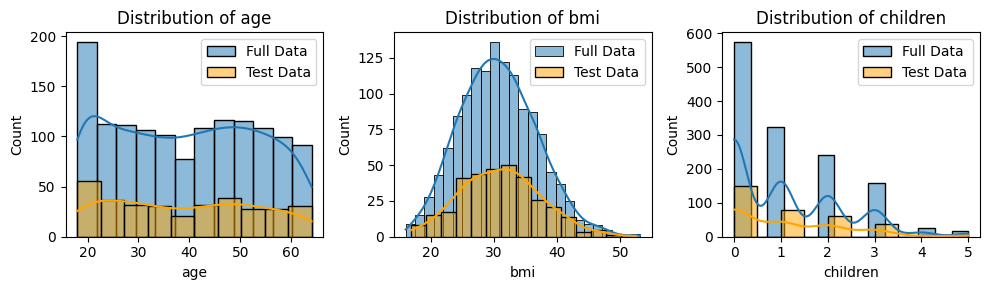

In [115]:
# Combine them into a single DataFrame for easier analysis.
test_data = pd.concat([X_test, y_test], axis=1)

# Calculate descriptive statistics for the test data.
test_data_summary = test_data.describe()

# Calculate descriptive statistics for the entire dataset (df).
full_data_summary = df.describe()

# Compare the summary statistics for the test data and the entire dataset.
print("Test Data Summary:")
print(test_data_summary)
print("\nFull Data Summary:")
print(full_data_summary)

# Create histograms to compare the distributions of key features
# between the test data and the entire dataset.
plt.figure(figsize=(10, 3))
for i, feature in enumerate(['age', 'bmi', 'children']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[feature], label='Full Data', kde=True)
    sns.histplot(test_data[feature], label='Test Data', kde=True, color='orange')
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.show()


# Linear Regression

### Normal Equation with 3-fold Cross-Validation

I implemented scaling and normal equation with 3-fold Cross-Validation using the code below.

The error values are quite high, likely because charges can have very high values, causing the errors to be large in magnitude

In [116]:
# Pipeline for Normal Equation method (LinearRegression)
steps = [
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
]

normal_eq_pipe = Pipeline(steps)

# 3-fold cross-validation
cv_scores = cross_val_score(normal_eq_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

# Print MSE and RMSE scores
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print("MSE Scores:", mse_scores)
print("RMSE Scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

MSE Scores: [35004764.88327616 40262364.84514871 37577632.12865638]
RMSE Scores: [5916.48247553 6345.26318171 6130.05971657]
Average RMSE: 6130.601791268647


### Stochastic Gradient Descent

**Training Error**: Initially, with a small amount of training data, the training error is relatively low, because the model is overfitting. As the training set size increases, the training error rises, and eventually stabilizes around a higher RMSE value.

**Validation Error**: The validation error starts relatively high but decreases as more data is added to the training set, then it stabilizes in a range close to the training error.

MSE Scores: [35171656.46383675 40127539.63398162 37604246.39294419]
RMSE Scores: [5930.56965762 6334.6301892  6132.23013209]
Average RMSE: 6132.476659637742


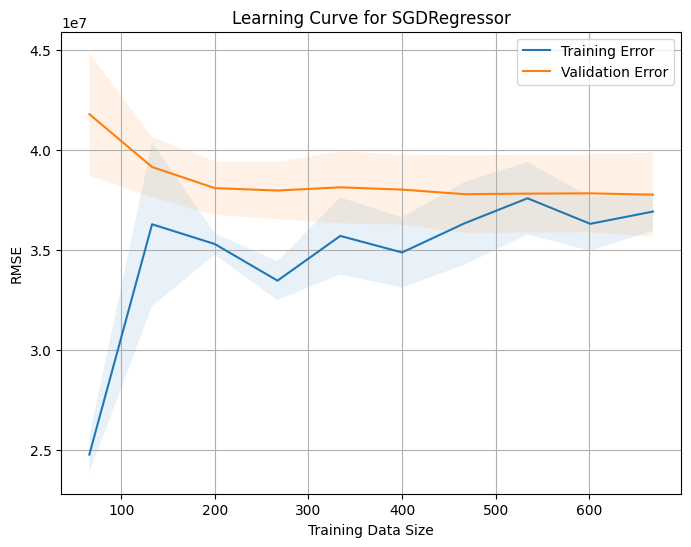

In [117]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import learning_curve
# Pipeline for SGDRegressor
steps = [
    ('scaler', StandardScaler()),
    ('model', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
]

sgd_pipe = Pipeline(steps)

# 3-fold cross-validation
cv_scores = cross_val_score(sgd_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

# Print MSE and RMSE scores
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print("MSE Scores:", mse_scores)
print("RMSE Scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    sgd_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation of scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, valid_scores_mean, label='Validation Error')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1)
plt.xlabel('Training Data Size')
plt.ylabel('RMSE')
plt.title('Learning Curve for SGDRegressor')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Regularization

#### Ridge

With an $alpha < 10$, the training and validation RMSE values stabilize around 6000. The gap between training and validation errors is small, which indicates that the model generalizes well and is not overfitting.

When I increase alpha to 100, the validation RMSE stabilizes around 6200. Since the regularization is stronger, the model is underfitting slightly compared to the lower alpha values.

MSE Scores for Ridge (alpha=1): [35231801.11787285 40246590.24261283 37662882.41880856]
RMSE Scores for Ridge (alpha=1): [5935.6382233  6344.02003801 6137.00924057]
Average RMSE for Ridge (alpha=1): 6138.889167290111
MSE Scores for Ridge (alpha=10): [35348671.18475261 40113735.89083132 37662094.12849106]
RMSE Scores for Ridge (alpha=10): [5945.47484939 6333.5405494  6136.94501593]
Average RMSE for Ridge (alpha=10): 6138.653471570794
MSE Scores for Ridge (alpha=100): [37106046.45182803 39535933.14109175 38368446.45088436]
RMSE Scores for Ridge (alpha=100): [6091.47325791 6287.76058236 6194.22686466]
Average RMSE for Ridge (alpha=100): 6191.153568310415


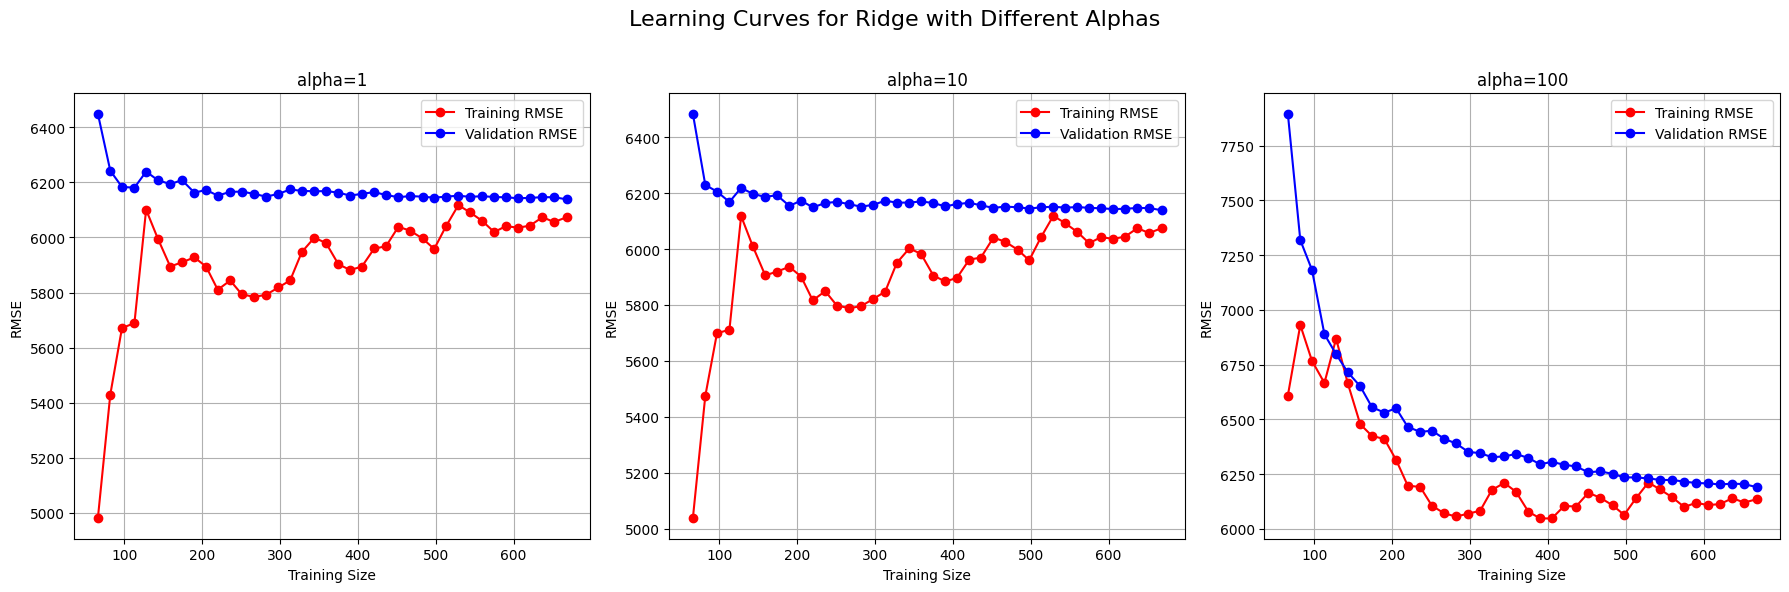

Best alpha for Ridge: 10
Best average RMSE for Ridge: 6138.653471570794


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score

# Define alphas to test
alphas = [1, 10, 100]
best_rmse = np.inf
best_alpha = None

# Set up the figure with 1x3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(alphas), figsize=(18, 6))  # Adjust figure size

for i, alpha in enumerate(alphas):
    steps = [
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=alpha))
    ]
    ridge_pipe = Pipeline(steps)

    # 3-fold cross-validation
    cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"MSE Scores for Ridge (alpha={alpha}):", mse_scores)
    print(f"RMSE Scores for Ridge (alpha={alpha}):", rmse_scores)

    avg_rmse = np.mean(rmse_scores)
    print(f"Average RMSE for Ridge (alpha={alpha}):", avg_rmse)

    # Keep track of the best alpha
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_alpha = alpha

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(ridge_pipe, X_train, y_train, cv=3,
                                                           scoring='neg_root_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

    # Plot learning curve in the corresponding subplot
    ax = axes[i]
    ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label="Training RMSE")
    ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label="Validation RMSE")
    ax.set_title(f"alpha={alpha}")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    ax.grid(True)

# Show the full plot with all 3 subplots
plt.suptitle("Learning Curves for Ridge with Different Alphas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title doesn't overlap
plt.show()

# Print the best alpha
print("Best alpha for Ridge:", best_alpha)
print("Best average RMSE for Ridge:", best_rmse)


#### Lasso

Lasso Regression with alpha values ranging from 1 to 100 showed similar performance across the different levels of regularization, the average validation RMSE values remaining close to 6200.

I plotted the coefficients from the Lasso Regression model with alpha=10. Smoker_No has the largest negative coefficient, indicating a strong negative impact on charges for non-smokers. Other features, like region and bmi, have much smaller coefficients, implying a minimal impact on charges compared to the smoking status. Sex, age, and region show almost negligible coefficients.

MSE Scores for Lasso (alpha=1): [35220519.31016918 40259779.13085125 37662682.21571613]
RMSE Scores for Lasso (alpha=1): [5934.68780225 6345.0594269  6136.99292942]
Average RMSE for Lasso (alpha=1): 6138.913386187804
MSE Scores for Lasso (alpha=10): [35229145.67264404 40241843.65633512 37651918.76072013]
RMSE Scores for Lasso (alpha=10): [5935.4145325  6343.64592772 6136.11593443]
Average RMSE for Lasso (alpha=10): 6138.392131551141
MSE Scores for Lasso (alpha=100): [35369973.46151999 40012642.88623777 37601153.37854662]
RMSE Scores for Lasso (alpha=100): [5947.26604933 6325.55474929 6131.97793363]
Average RMSE for Lasso (alpha=100): 6134.932910750045


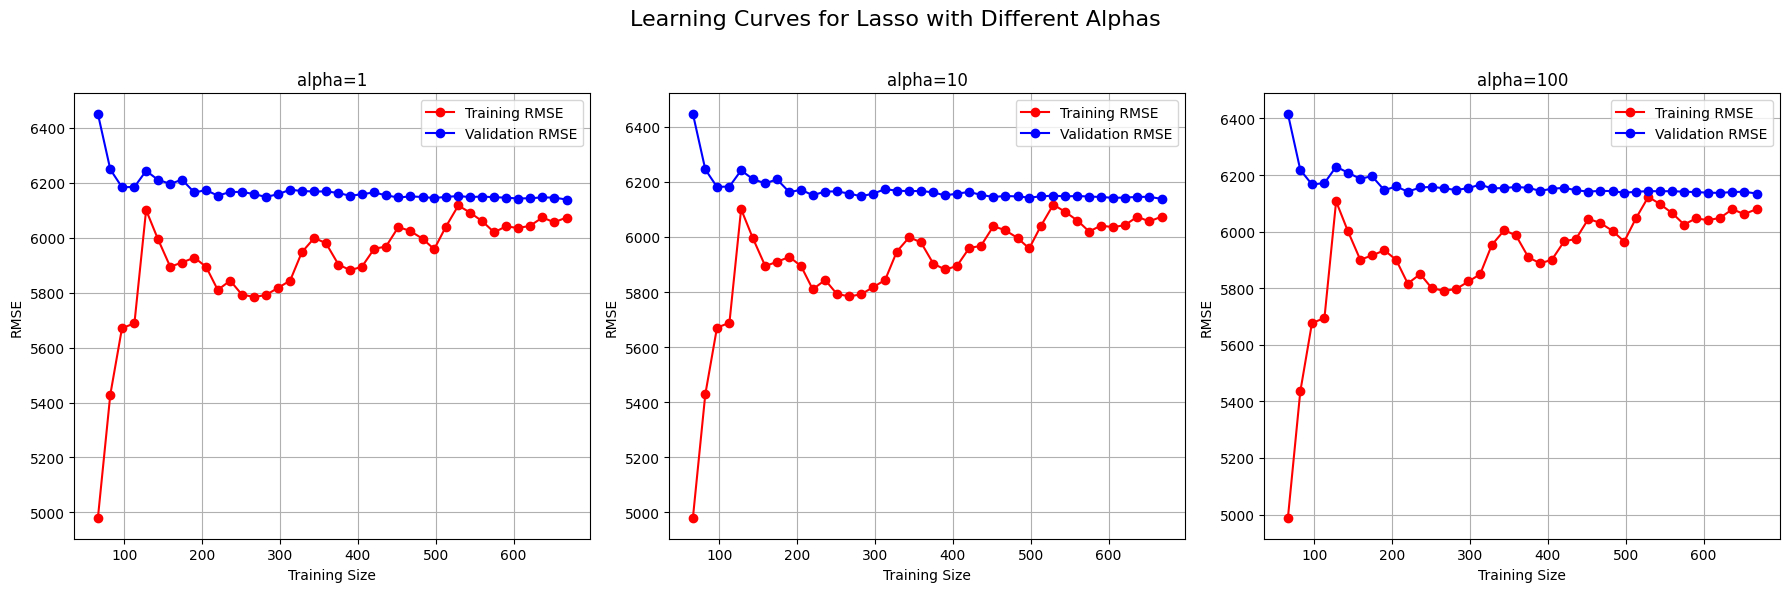

Best alpha for Lasso: 100
Best average RMSE for Lasso: 6134.932910750045


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score

# Define alphas to test
alphas = [1, 10, 100]
best_rmse = np.inf
best_alpha = None

# Set up the figure with 1x3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(alphas), figsize=(18, 6))  # Adjust figure size

for i, alpha in enumerate(alphas):
    steps = [
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=alpha))
    ]
    lasso_pipe = Pipeline(steps)

    # 3-fold cross-validation
    cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"MSE Scores for Lasso (alpha={alpha}):", mse_scores)
    print(f"RMSE Scores for Lasso (alpha={alpha}):", rmse_scores)

    avg_rmse = np.mean(rmse_scores)
    print(f"Average RMSE for Lasso (alpha={alpha}):", avg_rmse)

    # Keep track of the best alpha
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_alpha = alpha

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(lasso_pipe, X_train, y_train, cv=3,
                                                           scoring='neg_root_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

    # Plot learning curve in the corresponding subplot
    ax = axes[i]
    ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label="Training RMSE")
    ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label="Validation RMSE")
    ax.set_title(f"alpha={alpha}")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    ax.grid(True)

# Show the full plot with all 3 subplots
plt.suptitle("Learning Curves for Lasso with Different Alphas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print the best alpha
print("Best alpha for Lasso:", best_alpha)
print("Best average RMSE for Lasso:", best_rmse)


Train RMSE for Lasso (alpha=10): 6083.354131509991
Test RMSE for Lasso (alpha=10): 5929.077259798222
Lasso picked 10 variables and eliminated the other 1 variables


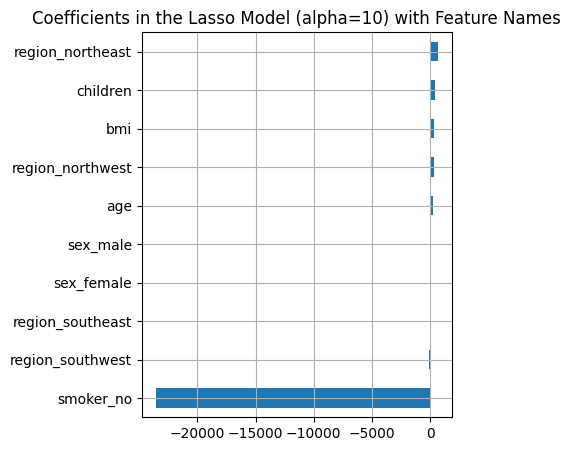

In [120]:
from sklearn.linear_model import Lasso
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Perform Lasso regression using the best alpha (0.01)
model_lasso = Lasso(alpha=10).fit(X_train, y_train)

# Cross-validation RMSE
y_train_pred = model_lasso.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Train RMSE for Lasso (alpha=10): {rmse_train}")

y_test_pred = model_lasso.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE for Lasso (alpha=10): {rmse_test}")

# Coefficients of the Lasso model
feature_names = [col for col in df_encoded.columns if col != 'charges']
coef = pd.Series(model_lasso.coef_, index=feature_names)

# Number of selected and eliminated variables
print(f"Lasso picked {sum(coef != 0)} variables and eliminated the other {sum(coef == 0)} variables")

# Plot the most important coefficients selected by Lasso
#imp_coef_worst = coef[coef != 0].sort_values().head(12)
imp_coef_best = coef[coef != 0].sort_values().tail(12)

plt.figure(figsize=(4, 5))
imp_coef_best.plot(kind="barh")
plt.title("Coefficients in the Lasso Model (alpha=10) with Feature Names")
plt.grid(True)
plt.show()


#### Elastic Net

Next, I did ElasticNet regularization with different combinations of alpha and l1_ratio parameters. alpha=0.1 and l1_ratio=0.8 performs the best with the lowest RMSE (6138.86), very similar to what was observed with Lasso and Ridge.

MSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.2): [36078894.98917659 39680470.34488443 37859427.51030307]
RMSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.2): [6006.57098428 6299.24363276 6153.00150417]
Average RMSE for ElasticNet (alpha=0.1, l1_ratio=0.2): 6152.938707069545
MSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.5): [35710359.22602995 39839856.52203214 37729807.97543077]
RMSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.5): [5975.81452407 6311.88216953 6142.45944028]
Average RMSE for ElasticNet (alpha=0.1, l1_ratio=0.5): 6143.385377957006
MSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.8): [35395640.39149825 40067951.86240495 37665620.85158485]
RMSE Scores for ElasticNet (alpha=0.1, l1_ratio=0.8): [5949.42353439 6329.92510717 6137.2323446 ]
Average RMSE for ElasticNet (alpha=0.1, l1_ratio=0.8): 6138.860328718546
MSE Scores for ElasticNet (alpha=1, l1_ratio=0.2): [51024099.32293886 45311584.86620516 48927139.41951548]
RMSE Scores for ElasticNet (alpha=1, l1_ratio=0.2): [

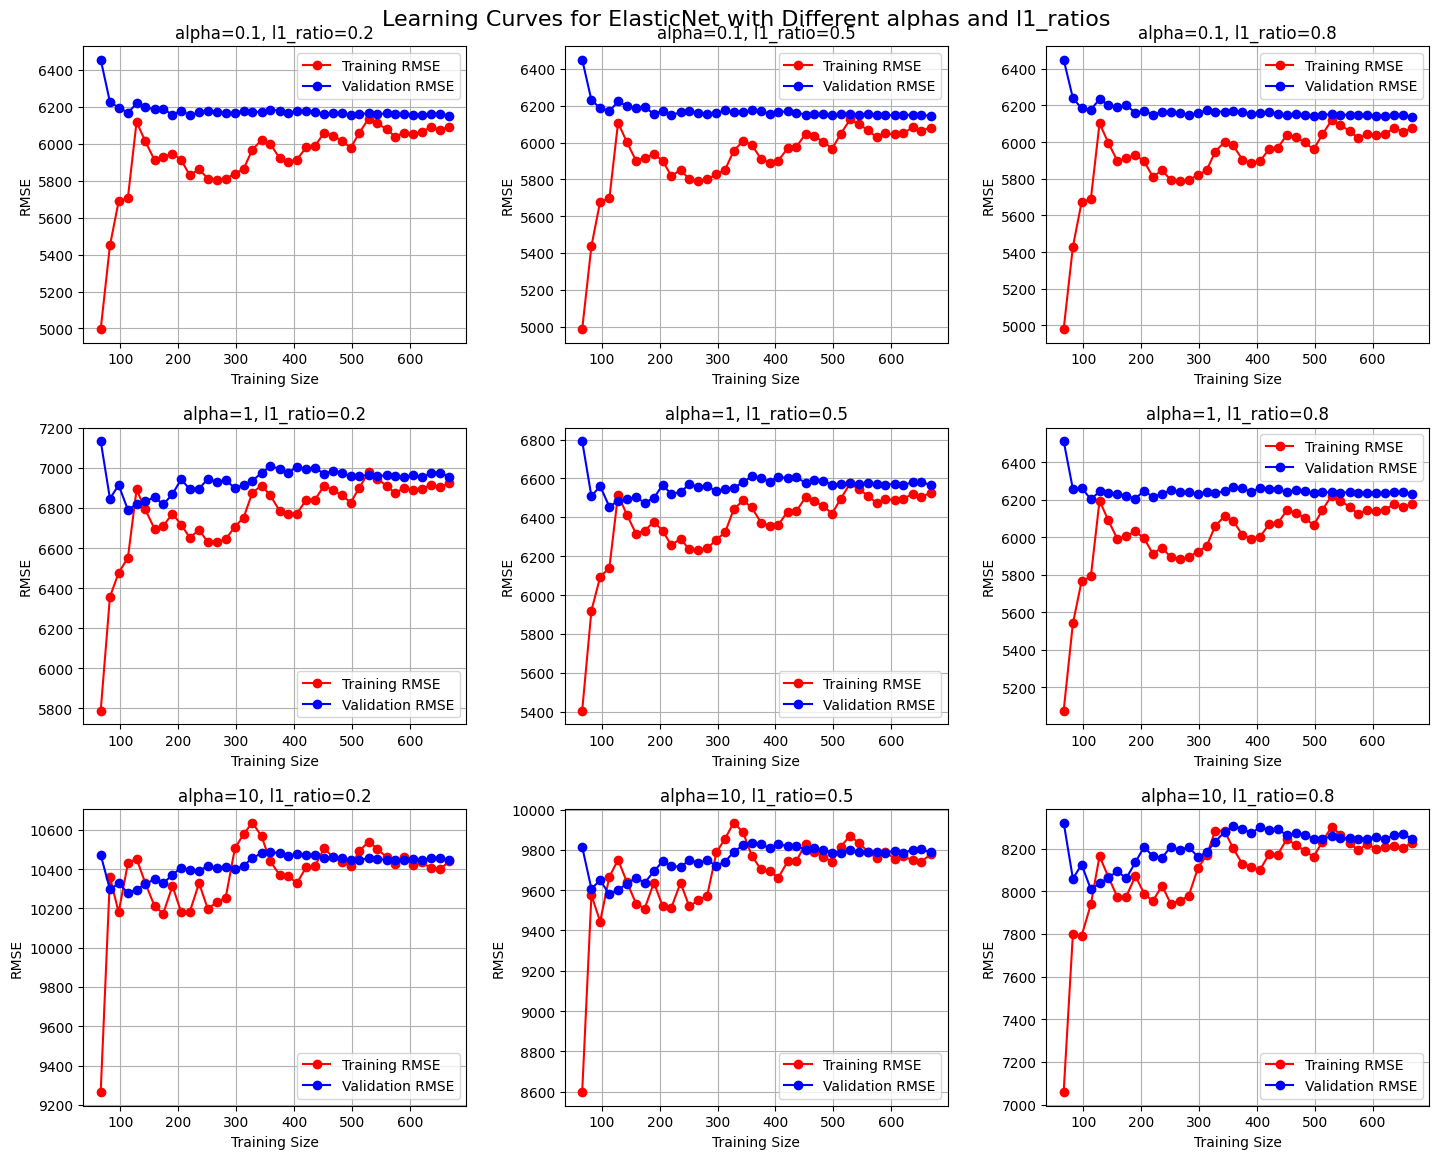

Best alpha for ElasticNet: 0.1
Best l1_ratio for ElasticNet: 0.8
Best average RMSE for ElasticNet: 6138.860328718546


In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score

# Define alphas and l1_ratios
alphas = [0.1, 1, 10]
l1_ratios = [0.2, 0.5, 0.8]
best_rmse = np.inf
best_l1_ratio = None

# Set up the figure with 3x3 subplots
fig, axes = plt.subplots(len(alphas), len(l1_ratios), figsize=(15, 12))
fig.tight_layout(pad=4.0)  # Adjust spacing

for i, alpha in enumerate(alphas):
    for j, l1_ratio in enumerate(l1_ratios):
        steps = [
            ('scaler', StandardScaler()),
            ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
        ]
        elastic_pipe = Pipeline(steps)

        # 3-fold cross-validation
        cv_scores = cross_val_score(elastic_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
        mse_scores = -cv_scores
        rmse_scores = np.sqrt(mse_scores)
        print(f"MSE Scores for ElasticNet (alpha={alpha}, l1_ratio={l1_ratio}):", mse_scores)
        print(f"RMSE Scores for ElasticNet (alpha={alpha}, l1_ratio={l1_ratio}):", rmse_scores)

        avg_rmse = np.mean(rmse_scores)
        print(f"Average RMSE for ElasticNet (alpha={alpha}, l1_ratio={l1_ratio}):", avg_rmse)

        # Keep track of the best l1_ratio
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_l1_ratio = l1_ratio
            best_alpha = alpha

        # Learning curve
        train_sizes, train_scores, val_scores = learning_curve(elastic_pipe, X_train, y_train, cv=3,
                                                              scoring='neg_root_mean_squared_error',
                                                              train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

        # Plot learning curve on the corresponding subplot
        ax = axes[i, j]
        ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label=f"Training RMSE")
        ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label=f"Validation RMSE")
        ax.set_title(f"alpha={alpha}, l1_ratio={l1_ratio}")
        ax.set_xlabel("Training Size")
        ax.set_ylabel("RMSE")
        ax.legend(loc="best")
        ax.grid(True)

# Show the full plot with all 9 subplots
plt.suptitle("Learning Curves for ElasticNet with Different alphas and l1_ratios", fontsize=16)
plt.show()

# Print the best alpha and l1_ratio
print("Best alpha for ElasticNet:", best_alpha)
print("Best l1_ratio for ElasticNet:", best_l1_ratio)
print("Best average RMSE for ElasticNet:", best_rmse)


### Discussion
Three different regularizations were done, but they do not significantly improve model performance, suggesting that linear models may have reached their limit for this dataset.

Lasso performed well with an alpha of 10, achieving a stable RMSE around 6135.
Ridge regression with a higher alpha (100) resulted in a slightly higher RMSE (6191.15) compared to Lasso, but it still performed well.
ElasticNet performed best with alpha=0.1 and l1_ratio=0.8, yielding RMSE values (6138.86) very close to Lasso.

### Other Hyperparameters Fine-Tuning

#### Batch Size

Batch Gradient Descent outperforms the regularized models (Lasso, Ridge, and ElasticNet) in terms of RMSE, achieving the lowest error (5926.02). This suggests that the linear model using BGD may be effectively capturing the relationships in the data. This is the best model till now.

In [122]:
import numpy as np
from sklearn.metrics import mean_squared_error

def batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000):
  """
  Performs batch gradient descent to find the optimal model parameters.

  Args:
    X: Feature matrix.
    y: Target vector.
    learning_rate: Learning rate for gradient descent.
    n_iterations: Number of iterations for gradient descent.

  Returns:
    theta: Optimized model parameters.
  """

  n_samples, n_features = X.shape
  theta = np.zeros(n_features)  # Initialize parameters

  for _ in range(n_iterations):
    y_pred = np.dot(X, theta)
    error = y_pred - y
    gradient = (1 / n_samples) * np.dot(X.T, error)  # Gradient of cost function
    theta = theta - learning_rate * gradient

  return theta


# Scale your data (X_train, X_test) using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a bias term to X_train_scaled (column of 1s)
X_train_scaled_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]

# Run batch gradient descent
theta = batch_gradient_descent(X_train_scaled_bias, y_train)

# Make predictions on the test set
X_test_scaled_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
y_pred = np.dot(X_test_scaled_bias, theta)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE for Batch Gradient Descent: {mse}")
print(f"RMSE for Batch Gradient Descent: {rmse}")

MSE for Batch Gradient Descent: 35117693.59547776
RMSE for Batch Gradient Descent: 5926.018359360504


#### Learning Rate

At a very low learning rate (1e-05), the training and validation RMSE decrease steadily but slowly, never fully converging to the best model by the end of 100 epochs. The RMSE decreases much faster and stabilizes around 6000 after about 50 epochs when learning rate is 0.0001. The RMSE decreases very rapidly in the first few epochs and stabilizes at the lowest RMSE around 6000 when learning rate is 0.001. Learning Rate 0.001 converges faster, but it may be more prone to volatility and overfitting.

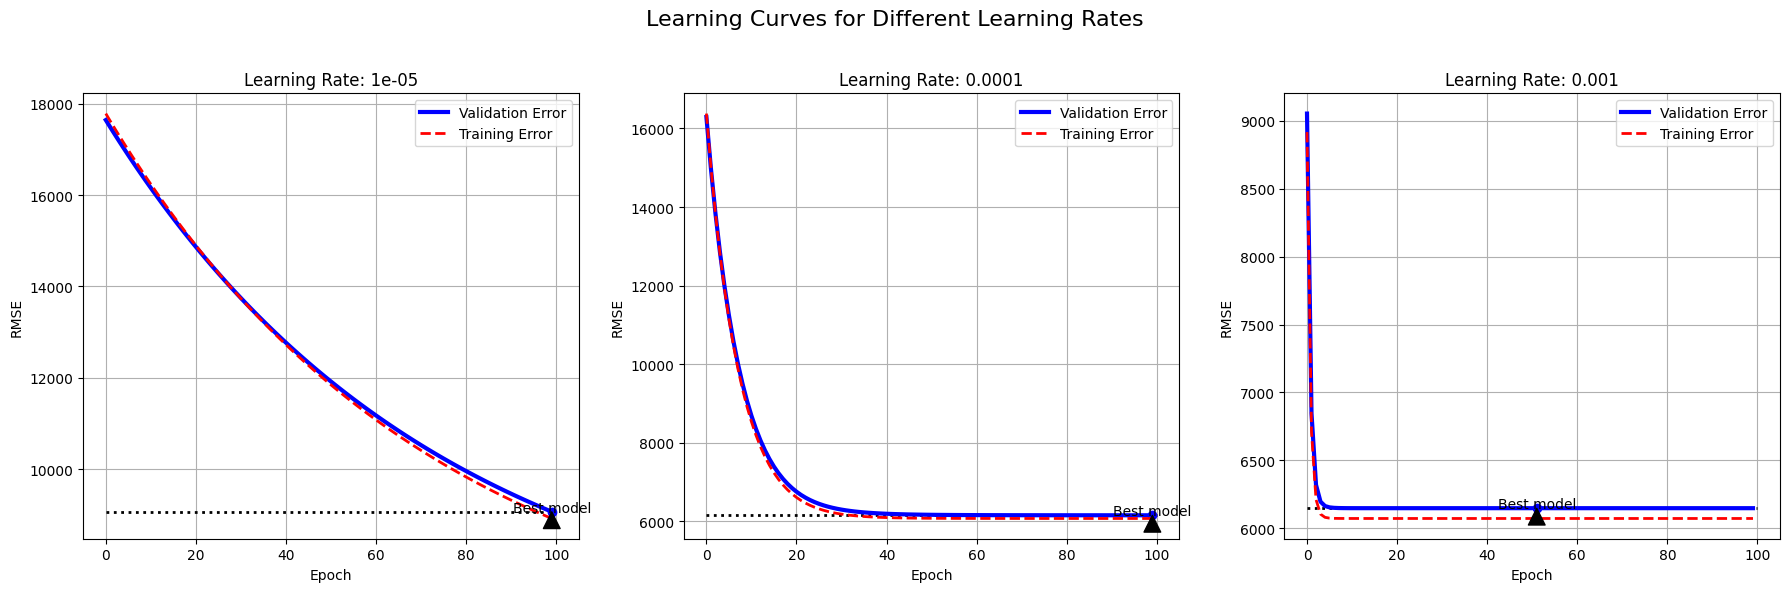

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy

# Assuming X and y are already defined
learning_rates = [0.00001, 0.0001, 0.001]  # Adjusted learning rates for better convergence

# Set up the figure with 1x3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(learning_rates), figsize=(18, 6))  # Adjust figure size

for i, eta0 in enumerate(learning_rates):
    # Split into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Scaling pipeline (only StandardScaler)
    linear_scaler = Pipeline([
        ("std_scaler", StandardScaler()),
    ])

    # Apply scaling to the training and validation sets
    X_train_linear_scaled = linear_scaler.fit_transform(X_train)
    X_val_linear_scaled = linear_scaler.transform(X_val)

    # Initialize SGDRegressor
    sgd_reg = SGDRegressor(penalty=None, max_iter=1000, tol=1e-3, random_state=42, eta0=eta0, learning_rate='constant')
    best_valid_rmse = float('inf')
    train_errors, val_errors = [], []
    n_epochs = 100

    for epoch in range(n_epochs):
        # Incremental learning with partial_fit
        sgd_reg.partial_fit(X_train_linear_scaled, y_train)

        # Predict on validation set and calculate RMSE
        y_val_predict = sgd_reg.predict(X_val_linear_scaled)
        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))  # RMSE for validation

        if val_error < best_valid_rmse:
            best_valid_rmse = val_error
            best_model = deepcopy(sgd_reg)

        # Predict on training set and calculate RMSE
        y_train_predict = sgd_reg.predict(X_train_linear_scaled)
        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))  # RMSE for training

        # Store errors for plotting
        val_errors.append(val_error)
        train_errors.append(train_error)

    # Plotting the training and validation errors over epochs in the corresponding subplot
    ax = axes[i]
    best_epoch = np.argmin(val_errors)
    ax.annotate('Best model',
                 xy=(best_epoch, best_valid_rmse),
                 xytext=(best_epoch, best_valid_rmse + 0.5),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.05))
    ax.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
    ax.plot(val_errors, "b-", linewidth=3, label="Validation Error")
    ax.plot(best_epoch, best_valid_rmse, "bo")
    ax.plot(train_errors, "r--", linewidth=2, label="Training Error")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE")
    ax.set_title(f"Learning Rate: {eta0}")
    ax.legend(loc="upper right")
    ax.grid(True)

# Show the full plot with all 3 subplots
plt.suptitle("Learning Curves for Different Learning Rates", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title doesn't overlap
plt.show()


Learning Rate: 1e-05
MSE Scores for SGDRegressor: [35489113.96752229 41071289.2179252  36548963.392073  ]
RMSE Scores for SGDRegressor: [5957.27403831 6408.68857239 6045.57386789]
Average RMSE: 6137.17882619664
Learning Rate: 0.0001
MSE Scores for SGDRegressor: [35493369.17477051 41080187.93310779 36540537.48772015]
RMSE Scores for SGDRegressor: [5957.63117143 6409.38280438 6044.87696217]
Average RMSE: 6137.296979325194
Learning Rate: 0.001
MSE Scores for SGDRegressor: [35607404.41102308 41113145.43911043 36529788.13026962]
RMSE Scores for SGDRegressor: [5967.19401486 6411.95332478 6043.98776722]
Average RMSE: 6141.045035618982


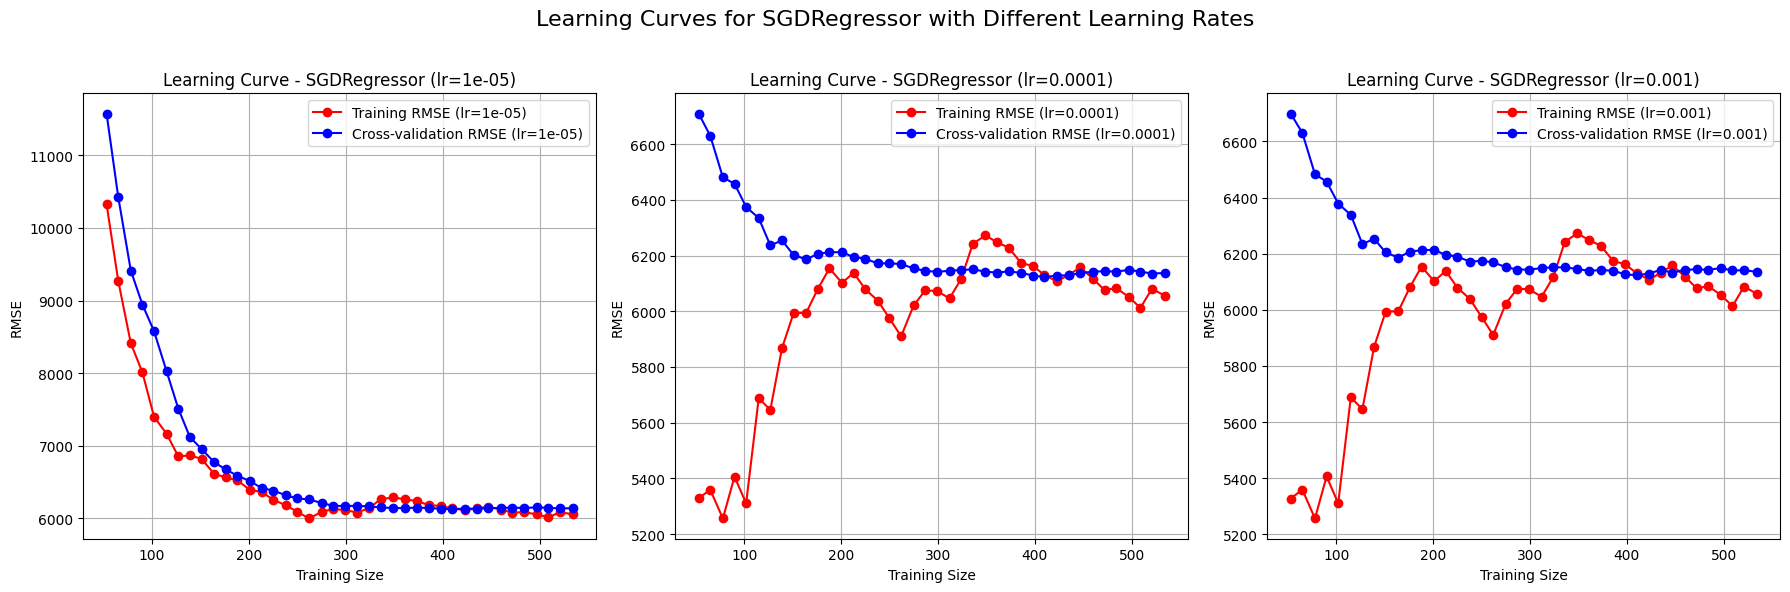

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Set up the figure with 1x3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(learning_rates), figsize=(18, 6))  # Adjust figure size

for i, learning_rate in enumerate(learning_rates):
    steps = [
        ('scaler', StandardScaler()),
        ('model', SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=learning_rate))
    ]

    sgd_pipe = Pipeline(steps)

    # 3-fold cross-validation
    cv_scores = cross_val_score(sgd_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"Learning Rate: {learning_rate}")
    print(f"MSE Scores for SGDRegressor:", mse_scores)
    print(f"RMSE Scores for SGDRegressor:", rmse_scores)
    print(f"Average RMSE:", np.mean(rmse_scores))

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(sgd_pipe, X_train, y_train, cv=3,
                                                           scoring='neg_root_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1.0, 40))

    # Plot learning curve in the corresponding subplot
    ax = axes[i]
    ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label=f"Training RMSE (lr={learning_rate})")
    ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label=f"Cross-validation RMSE (lr={learning_rate})")
    ax.set_title(f"Learning Curve - SGDRegressor (lr={learning_rate})")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    ax.grid(True)

# Show the full plot with all 3 subplots
plt.suptitle("Learning Curves for SGDRegressor with Different Learning Rates", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title doesn't overlap
plt.show()


### Prediction with Linear Model

I performed prediction using the best linear model I got: the Batch Gradient Descent model.

The R² score of 0.7673 suggests that this model explains 76.73% of the variance in the target variable (insurance charges), meaning the model fits the data fairly well.

Further improvements could be explored by either fine-tuning the learning rate, batch size, or moving to more complex models.

In [125]:
# Make predictions on the test set
X_test_scaled_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
y_pred = np.dot(X_test_scaled_bias, theta)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE for Batch Gradient Descent: {mse}")
print(f"RMSE for Batch Gradient Descent: {rmse}")

linear_r2 = r2_score(y_test, y_pred)
print(f"Linear Model R²: {linear_r2}")

MSE for Batch Gradient Descent: 35117693.59547776
RMSE for Batch Gradient Descent: 5926.018359360504
Linear Model R²: 0.767264707097872


# Polynomial Regression

### Normal Equation

The Polynomial Regression (degree=2) model achieves the lowest RMSE (4,947.58), which beats all linear models I have tried so far. This suggests that introducing non-linear terms (polynomials) significantly improved the model’s ability to capture the relationships in the data.

In [126]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Define the degree of the polynomial
degree = 2

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)

# Create a Normal Equation model
model_poly = LinearRegression()

# Perform 3-fold cross-validation
cv_scores = cross_val_score(model_poly, X_train_poly, y_train, cv=3, scoring='neg_mean_squared_error')

# Calculate the RMSE scores
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)

print(f"MSE Scores for Polynomial Regression (degree={degree}):", mse_scores)
print(f"RMSE Scores for Polynomial Regression (degree={degree}):", rmse_scores)
print(f"Average RMSE for Polynomial Regression (degree={degree}):", np.mean(rmse_scores))

MSE Scores for Polynomial Regression (degree=2): [22807867.44603359 27140452.48646922 23593761.95433843]
RMSE Scores for Polynomial Regression (degree=2): [4775.7583111  5209.64993896 4857.34103747]
Average RMSE for Polynomial Regression (degree=2): 4947.583095843567


### SGD

The average RMSE of 5,022.78 is slightly higher than the closed-form solution's RMSE of 4,947.58, indicating that the closed-form method performs better so far. The learning curve shows that the training RMSE stabilizes around 4,500, while the cross-validation RMSE hovers around 5,000. This suggests that the model is performing well but may still slightly overfit the training data, as there's a small gap between training and validation RMSE.

MSE Scores for Polynomial Regression with SGD (degree=2): [22599165.93998072 28838000.37085652 25191113.26603492]
RMSE Scores for Polynomial Regression with SGD (degree=2): [4753.85800587 5370.10245441 5019.07494127]
Average RMSE for Polynomial Regression with SGD (degree=2): 5047.678467181796


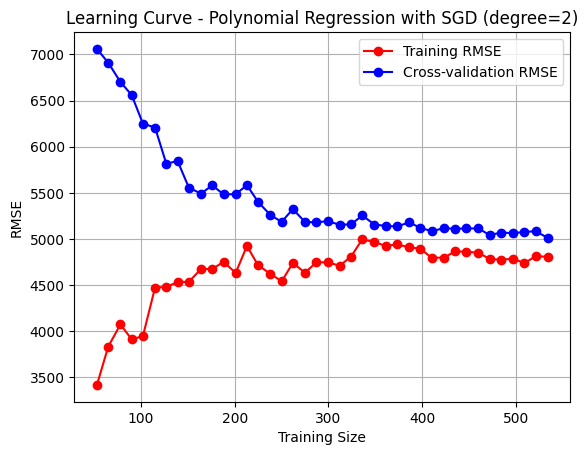

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from copy import deepcopy


# Define the degree of the polynomial
degree = 2

# Create a pipeline for polynomial features and SGDRegressor
steps = [
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('scaler', StandardScaler()),
    ('model', SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.001))
]

poly_sgd_pipe = Pipeline(steps)

# 3-fold cross-validation
cv_scores = cross_val_score(poly_sgd_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print(f"MSE Scores for Polynomial Regression with SGD (degree={degree}):", mse_scores)
print(f"RMSE Scores for Polynomial Regression with SGD (degree={degree}):", rmse_scores)
print(f"Average RMSE for Polynomial Regression with SGD (degree={degree}):", np.mean(rmse_scores))


# Learning curve
train_sizes, train_scores, val_scores = learning_curve(poly_sgd_pipe, X_train, y_train, cv=3,
                                                       scoring='neg_root_mean_squared_error',
                                                       train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

# Plot learning curve
plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label="Cross-validation RMSE")
plt.title(f"Learning Curve - Polynomial Regression with SGD (degree={degree})")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Regularization

#### Ridge

Alpha = 1 yields the best results with the lowest average RMSE of 4,940.22, outperforming the other alpha values (0.1 and 10). The corresponding Polynomial Ridge Regression model (alpha = 1 and degree = 2) provides the best balance of performance and regularization so far.

Alpha: 0.1
MSE Scores for Polynomial Ridge Regression (degree=2): [22920996.3256145  27210904.9242356  23408144.90870015]
RMSE Scores for Polynomial Ridge Regression (degree=2): [4787.58773555 5216.40728128 4838.19645206]
Average RMSE for Polynomial Ridge Regression (degree=2): 4947.397156298098
Alpha: 1
MSE Scores for Polynomial Ridge Regression (degree=2): [22747930.16386844 27258907.16853352 23330685.55602875]
RMSE Scores for Polynomial Ridge Regression (degree=2): [4769.47902437 5221.00633676 4830.18483663]
Average RMSE for Polynomial Ridge Regression (degree=2): 4940.223399254126
Alpha: 10
MSE Scores for Polynomial Ridge Regression (degree=2): [23162166.40168893 28315825.31527377 23676484.3553874 ]
RMSE Scores for Polynomial Ridge Regression (degree=2): [4812.7088424  5321.26162815 4865.84878057]
Average RMSE for Polynomial Ridge Regression (degree=2): 4999.939750374499


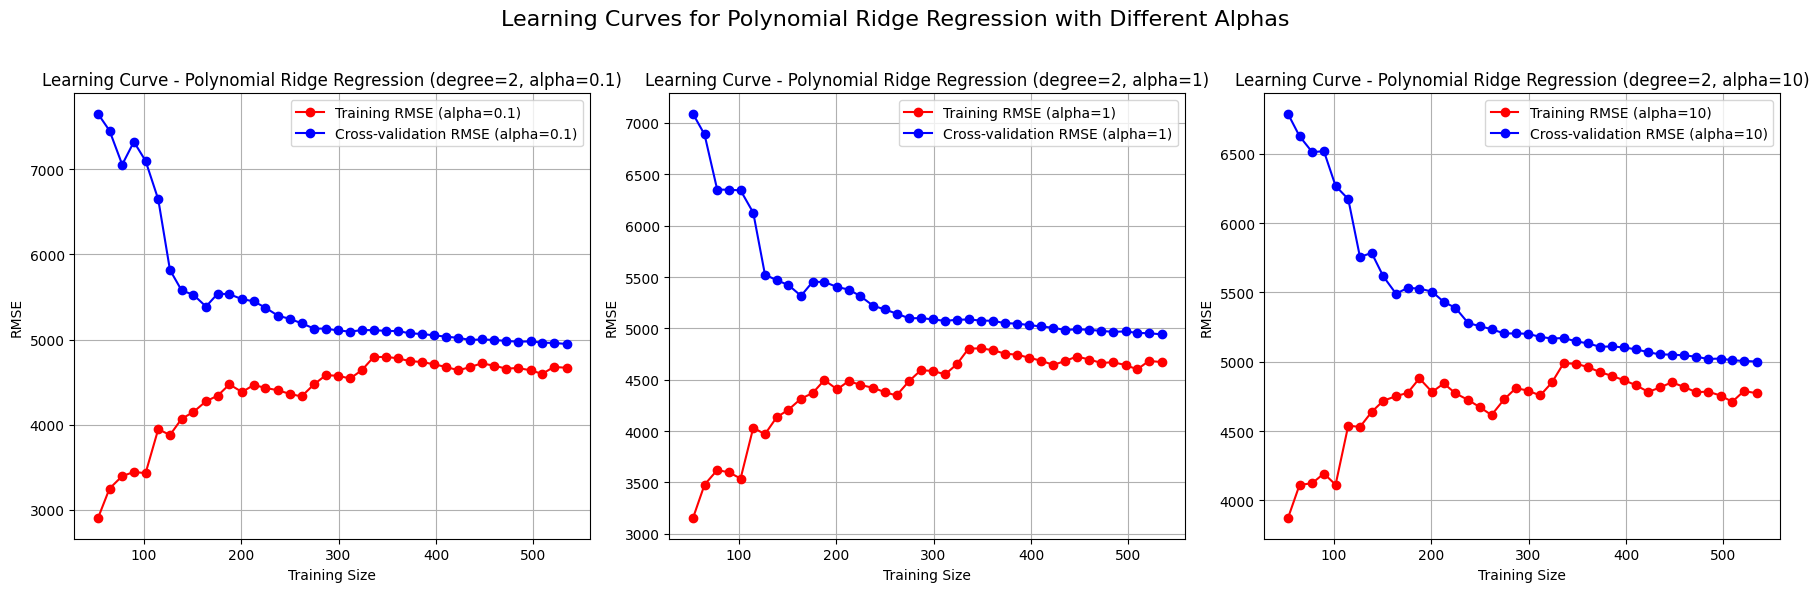

In [128]:
from copy import deepcopy

# Define the degree of the polynomial
degree = 2

# Define alphas to test
alphas = [0.1, 1, 10]

# Set up the figure with 1x4 subplots
fig, axes = plt.subplots(1, len(alphas), figsize=(18, 6))

for i, alpha in enumerate(alphas):
    steps = [
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=alpha))
    ]

    ridge_poly_pipe = Pipeline(steps)

    # 3-fold cross-validation
    cv_scores = cross_val_score(ridge_poly_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"Alpha: {alpha}")
    print(f"MSE Scores for Polynomial Ridge Regression (degree={degree}):", mse_scores)
    print(f"RMSE Scores for Polynomial Ridge Regression (degree={degree}):", rmse_scores)
    print(f"Average RMSE for Polynomial Ridge Regression (degree={degree}):", np.mean(rmse_scores))

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(ridge_poly_pipe, X_train, y_train, cv=3,
                                                           scoring='neg_root_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

    # Plot learning curve in the corresponding subplot
    ax = axes[i]
    ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label=f"Training RMSE (alpha={alpha})")
    ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label=f"Cross-validation RMSE (alpha={alpha})")
    ax.set_title(f"Learning Curve - Polynomial Ridge Regression (degree={degree}, alpha={alpha})")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    ax.grid(True)

# Show the full plot with all subplots
plt.suptitle("Learning Curves for Polynomial Ridge Regression with Different Alphas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Lasso

Polynomial Lasso Regression (alpha=10) has a RMSE of 4,923.89 (Best among all). Increasing the regularization strength (alpha=100) results in a higher RMSE (5004.65), showing that too much regularization starts to hurt performance.

I plotted the top positive and negative coefficients in the Lasso Model (alpha=10).


*   $({smoker\_no}) ^2$ is the largest positive coefficient, it has an overwhelmingly positive impact, indicating that non-smokers contribute significantly to higher insurance charges.
*   BMI is the second strong predictor, indicating that higher BMI leads to increased charges.



Alpha: 1
MSE Scores for Polynomial Lasso Regression (degree=2): [22883037.82104854 27185096.1127509  23410628.60429659]
RMSE Scores for Polynomial Lasso Regression (degree=2): [4783.6218309  5213.93288341 4838.45312102]
Average RMSE for Polynomial Lasso Regression (degree=2): 4945.33594511059
Alpha: 10
MSE Scores for Polynomial Lasso Regression (degree=2): [22374396.21286851 27105844.55673683 23378866.2489096 ]
RMSE Scores for Polynomial Lasso Regression (degree=2): [4730.15815939 5206.32735782 4835.16972286]
Average RMSE for Polynomial Lasso Regression (degree=2): 4923.885080024302
Alpha: 100
MSE Scores for Polynomial Lasso Regression (degree=2): [22624059.602569   28577601.88626934 24124412.05946058]
RMSE Scores for Polynomial Lasso Regression (degree=2): [4756.4755442  5345.80226779 4911.66082496]
Average RMSE for Polynomial Lasso Regression (degree=2): 5004.64621231578


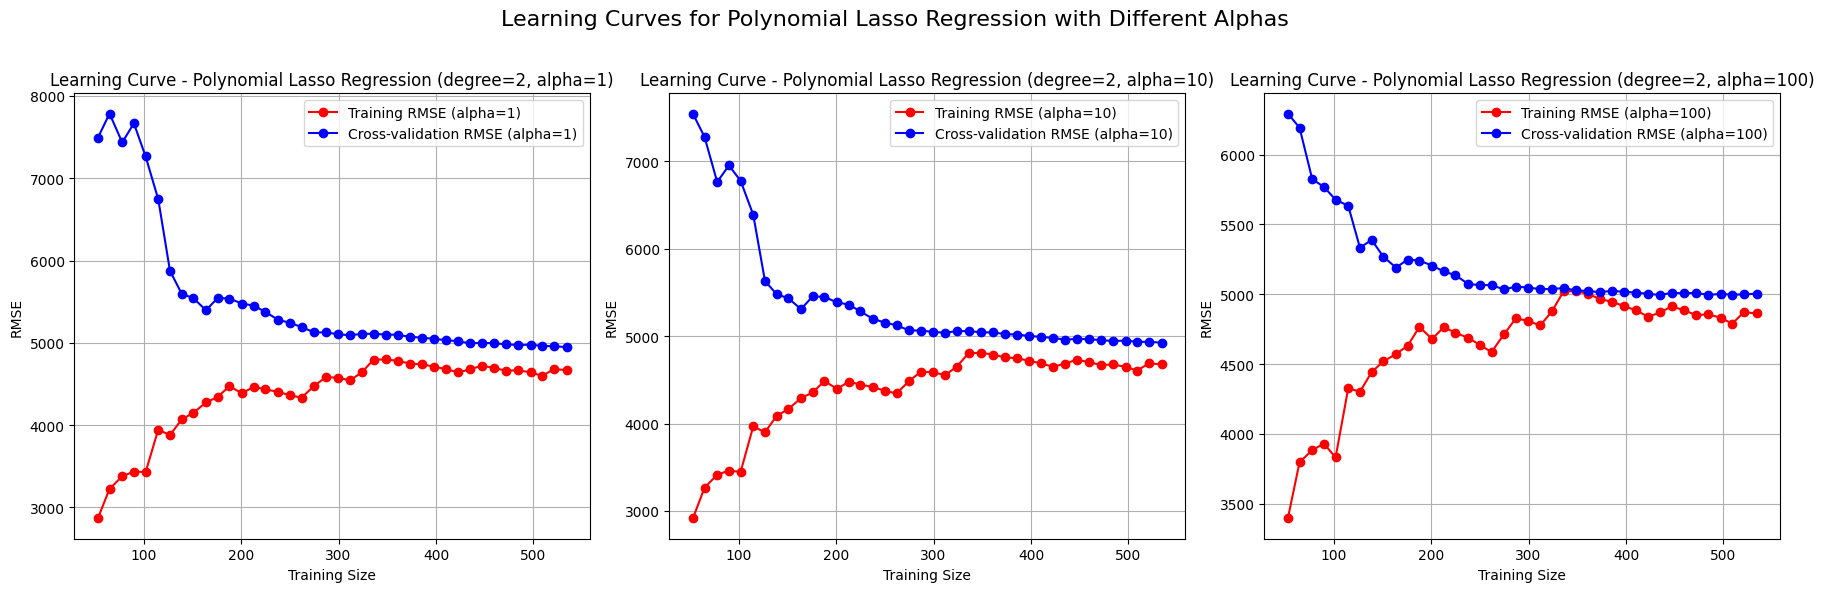

In [129]:
from sklearn.linear_model import Lasso
from copy import deepcopy

# Define the degree of the polynomial
degree = 2

# Define alphas to test
alphas = [1, 10, 100]

# Set up the figure with 1x4 subplots
fig, axes = plt.subplots(1, len(alphas), figsize=(18, 6))

for i, alpha in enumerate(alphas):
    steps = [
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=alpha, max_iter=10000))
    ]

    lasso_poly_pipe = Pipeline(steps)

    # 3-fold cross-validation
    cv_scores = cross_val_score(lasso_poly_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"Alpha: {alpha}")
    print(f"MSE Scores for Polynomial Lasso Regression (degree={degree}):", mse_scores)
    print(f"RMSE Scores for Polynomial Lasso Regression (degree={degree}):", rmse_scores)
    print(f"Average RMSE for Polynomial Lasso Regression (degree={degree}):", np.mean(rmse_scores))

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(lasso_poly_pipe, X_train, y_train, cv=3,
                                                           scoring='neg_root_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1.0, 40), random_state=42)

    # Plot learning curve in the corresponding subplot
    ax = axes[i]
    ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label=f"Training RMSE (alpha={alpha})")
    ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label=f"Cross-validation RMSE (alpha={alpha})")
    ax.set_title(f"Learning Curve - Polynomial Lasso Regression (degree={degree}, alpha={alpha})")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    ax.grid(True)

# Show the full plot with all subplots
plt.suptitle("Learning Curves for Polynomial Lasso Regression with Different Alphas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Cross-Validation RMSE for Polynomial Regression with Lasso (alpha=10): 4927.878346732493
Lasso picked 32 variables and eliminated the other 45 variables


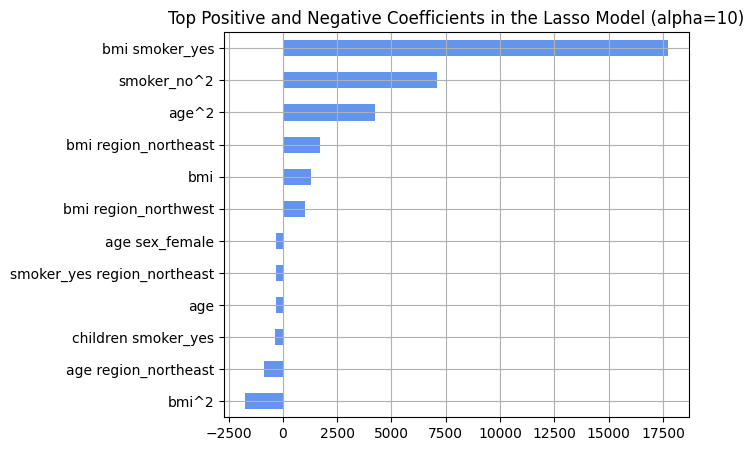

In [130]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the degree and alpha for polynomial regression with Lasso
degree = 2
alpha = 10

# Create a pipeline for polynomial features, scaling, and Lasso
steps = [
    ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
    ('scaler', StandardScaler()),  # Scaling the data is often important for regularization methods like Lasso
    ('model', Lasso(alpha=alpha, max_iter=10000))
]

lasso_poly_pipe = Pipeline(steps)

# Perform 3-fold cross-validation
kf = KFold(n_splits=3)
y_train_pred_cv = cross_val_predict(lasso_poly_pipe, X_train, y_train, cv=kf)

# Cross-validation RMSE
rmse_cv = np.sqrt(mean_squared_error(y_train, y_train_pred_cv))
print(f"Cross-Validation RMSE for Polynomial Regression with Lasso (alpha={alpha}): {rmse_cv}")

# Fit the pipeline model on the whole training set
lasso_poly_pipe.fit(X_train, y_train)

# Get the coefficients from the fitted model
# Extract the polynomial feature names
poly = lasso_poly_pipe.named_steps['poly_features']
feature_names = poly.get_feature_names_out([col for col in df_encoded.columns if col != 'charges'])

# Get the model coefficients
coef = pd.Series(lasso_poly_pipe.named_steps['model'].coef_, index=feature_names)

# Number of selected and eliminated variables
print(f"Lasso picked {sum(coef != 0)} variables and eliminated the other {sum(coef == 0)} variables")

# Plot the top 12 coefficients (both positive and negative)
imp_coef_top = coef[coef != 0].sort_values().head(6)  # 6 smallest coefficients (most negative)
imp_coef_bottom = coef[coef != 0].sort_values().tail(6)  # 6 largest coefficients (most positive)
imp_coef = pd.concat([imp_coef_top, imp_coef_bottom])  # Combine the top negative and positive coefficients

plt.figure(figsize=(6, 5))
imp_coef.plot(kind="barh", color="cornflowerblue")  # Set the color to cornflowerblue
plt.title(f"Top Positive and Negative Coefficients in the Lasso Model (alpha={alpha})")
plt.grid(True)
plt.show()


#### Elastic Net

The best-performing Elastic Net model in terms of the lowest average RMSE is when alpha=0.1 and l1_ratio=0.9, with an average RMSE of 4954.40. For each value of alpha, increasing the l1_ratio generally leads to a lower RMSE. This means more focus on the Lasso component (as l1_ratio approaches 1) tends to improve the model performance. Increasing alpha from 0.1 to 10 significantly increases the RMSE, suggesting that higher values of alpha (stronger regularization) may be too restrictive for the model.

Alpha: 0.1, l1_ratio: 0.1
MSE Scores for Polynomial ElasticNet Regression (degree=2): [27162450.61050582 31805475.53312966 26621601.11457664]
RMSE Scores for Polynomial ElasticNet Regression (degree=2): [5211.76079751 5639.63434392 5159.61249655]
Average RMSE for Polynomial ElasticNet Regression (degree=2): 5337.0025459956605
Alpha: 0.1, l1_ratio: 0.5
MSE Scores for Polynomial ElasticNet Regression (degree=2): [25259463.755526   30193330.86547122 25124850.27524247]
RMSE Scores for Polynomial ElasticNet Regression (degree=2): [5025.87940121 5494.84584547 5012.46947873]
Average RMSE for Polynomial ElasticNet Regression (degree=2): 5177.731575138482
Alpha: 0.1, l1_ratio: 0.9
MSE Scores for Polynomial ElasticNet Regression (degree=2): [22694416.85506113 27723197.08639704 23368068.16016594]
RMSE Scores for Polynomial ElasticNet Regression (degree=2): [4763.86574696 5265.28224186 4834.05297449]
Average RMSE for Polynomial ElasticNet Regression (degree=2): 4954.400321101524
Alpha: 1, l1_ratio

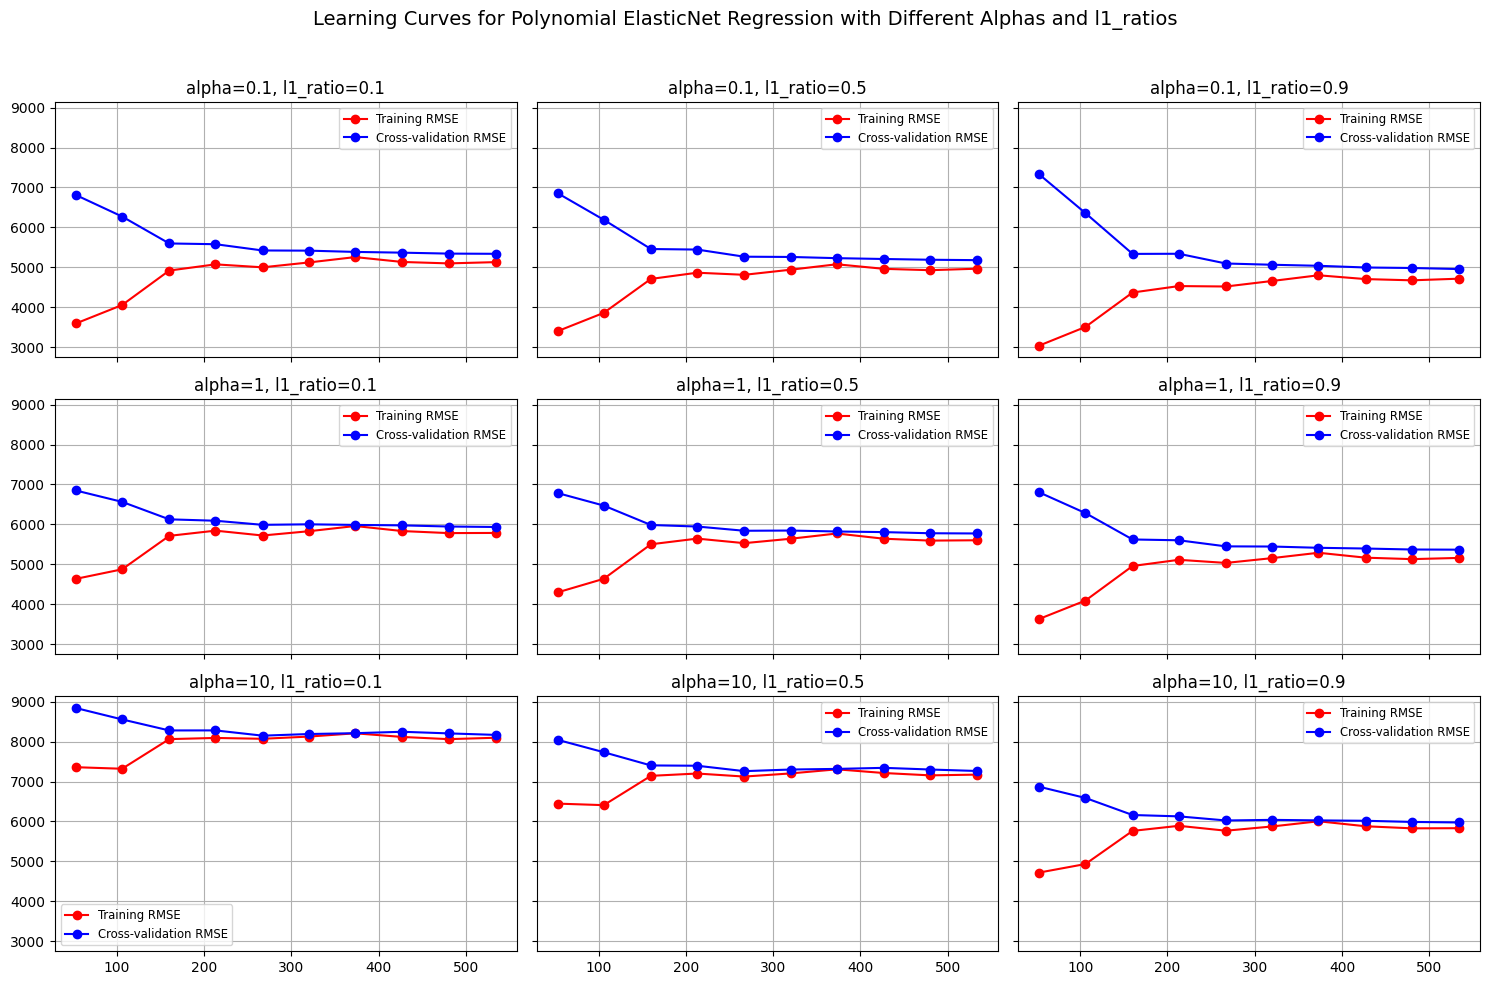

In [131]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import learning_curve, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the degree of the polynomial
degree = 2

# Define alphas and l1_ratios to test
alphas = [0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

# Set up the figure with subplots
fig, axes = plt.subplots(len(alphas), len(l1_ratios), figsize=(15, 10), sharex=True, sharey=True)

for i, alpha in enumerate(alphas):
    for j, l1_ratio in enumerate(l1_ratios):
        steps = [
            ('poly_features', PolynomialFeatures(degree=degree)),
            ('scaler', StandardScaler()),
            ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000))
        ]

        elasticnet_poly_pipe = Pipeline(steps)

        # 3-fold cross-validation
        cv_scores = cross_val_score(elasticnet_poly_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
        mse_scores = -cv_scores
        rmse_scores = np.sqrt(mse_scores)
        print(f"Alpha: {alpha}, l1_ratio: {l1_ratio}")
        print(f"MSE Scores for Polynomial ElasticNet Regression (degree={degree}):", mse_scores)
        print(f"RMSE Scores for Polynomial ElasticNet Regression (degree={degree}):", rmse_scores)
        print(f"Average RMSE for Polynomial ElasticNet Regression (degree={degree}):", np.mean(rmse_scores))

        # Learning curve
        train_sizes, train_scores, val_scores = learning_curve(elasticnet_poly_pipe, X_train, y_train, cv=3,
                                                               scoring='neg_root_mean_squared_error',
                                                               train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

        # Plot learning curve in the corresponding subplot
        ax = axes[i, j]
        ax.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label="Training RMSE")
        ax.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', color="b", label="Cross-validation RMSE")
        ax.set_title(f"alpha={alpha}, l1_ratio={l1_ratio}")
        ax.legend(loc="best", fontsize='small')
        ax.grid(True)

# Show the full plot with all subplots
plt.suptitle("Learning Curves for Polynomial ElasticNet Regression with Different Alphas and l1_ratios", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Other Hyperparameters

#### Batch Size

I did Batch Gradient Descent with for Polynomial Regression with degree=2 and both MSE and RMSE are quite high. The number of iterations may not be enough for convergence. Increasing the number of iterations could allow gradient descent to converge closer to the minimum of the cost function. In future work, mini-batch might be helpful.

In [132]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000):
    """
    Performs batch gradient descent to find the optimal model parameters.

    Args:
        X: Feature matrix.
        y: Target vector.
        learning_rate: Learning rate for gradient descent.
        n_iterations: Number of iterations for gradient descent.

    Returns:
        theta: Optimized model parameters.
    """
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)  # Initialize parameters

    for _ in range(n_iterations):
        y_pred = np.dot(X, theta)
        error = y_pred - y
        gradient = (1 / n_samples) * np.dot(X.T, error)  # Gradient of cost function
        theta = theta - learning_rate * gradient

    return theta

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2)

# Transform the input data to include polynomial terms
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Scale your data (X_train_poly, X_test_poly) using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Run batch gradient descent
theta = batch_gradient_descent(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = np.dot(X_test_scaled, theta)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE for Polynomial Regression (degree=2) with Batch Gradient Descent: {mse}")
print(f"RMSE for Polynomial Regression (degree=2) with Batch Gradient Descent: {rmse}")


MSE for Polynomial Regression (degree=2) with Batch Gradient Descent: 203742911.00098026
RMSE for Polynomial Regression (degree=2) with Batch Gradient Descent: 14273.854104655136


#### Learning Rate

The polynomial regression model with degree=2 has been evaluated using different learning rates (1e-5, 0.0001, and 0.001). The learning curves show the progression of training and validation errors across epochs.

Similar to what I have showed in the linear model: when the learning rate $\eta$ is too small, the RMSE is high, and convergence is slow.

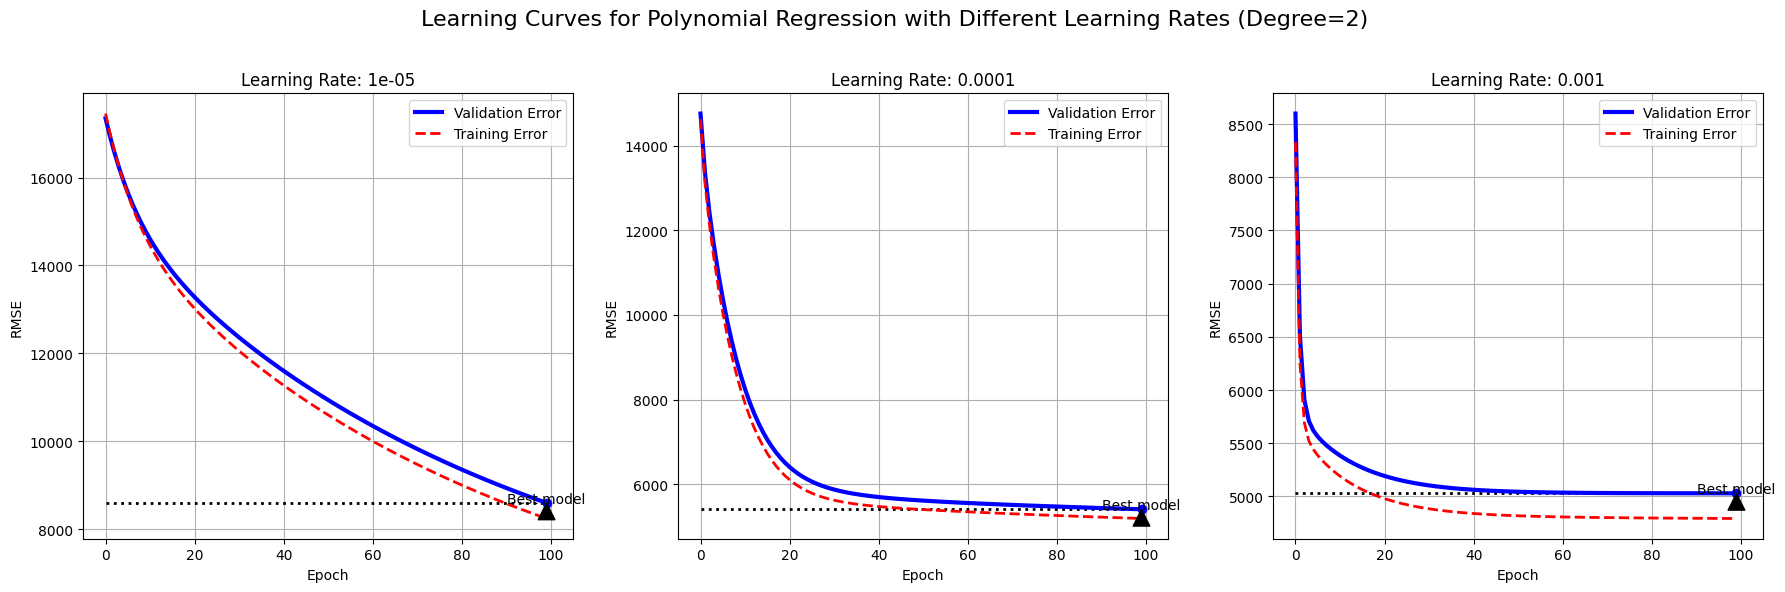

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from copy import deepcopy

# Assuming X and y are already defined
learning_rates = [0.00001, 0.0001, 0.001]  # Adjusted learning rates for better convergence

# Set up the figure with 1x3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(learning_rates), figsize=(18, 6))  # Adjust figure size

for i, eta0 in enumerate(learning_rates):
    # Split into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Polynomial and scaling pipeline (PolynomialFeatures + StandardScaler)
    poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

    # Apply scaling and polynomial transformation to the training and validation sets
    X_train_poly_scaled = poly_scaler.fit_transform(X_train)
    X_val_poly_scaled = poly_scaler.transform(X_val)

    # Initialize SGDRegressor
    sgd_reg = SGDRegressor(penalty=None, max_iter=1000, tol=1e-3, random_state=42, eta0=eta0, learning_rate='constant')
    best_valid_rmse = float('inf')
    train_errors, val_errors = [], []
    n_epochs = 100

    for epoch in range(n_epochs):
        # Incremental learning with partial_fit
        sgd_reg.partial_fit(X_train_poly_scaled, y_train)

        # Predict on validation set and calculate RMSE
        y_val_predict = sgd_reg.predict(X_val_poly_scaled)
        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))  # RMSE for validation

        if val_error < best_valid_rmse:
            best_valid_rmse = val_error
            best_model = deepcopy(sgd_reg)

        # Predict on training set and calculate RMSE
        y_train_predict = sgd_reg.predict(X_train_poly_scaled)
        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))  # RMSE for training

        # Store errors for plotting
        val_errors.append(val_error)
        train_errors.append(train_error)

    # Plotting the training and validation errors over epochs in the corresponding subplot
    ax = axes[i]
    best_epoch = np.argmin(val_errors)
    ax.annotate('Best model',
                 xy=(best_epoch, best_valid_rmse),
                 xytext=(best_epoch, best_valid_rmse + 0.5),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.05))
    ax.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
    ax.plot(val_errors, "b-", linewidth=3, label="Validation Error")
    ax.plot(best_epoch, best_valid_rmse, "bo")
    ax.plot(train_errors, "r--", linewidth=2, label="Training Error")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE")
    ax.set_title(f"Learning Rate: {eta0}")
    ax.legend(loc="upper right")
    ax.grid(True)

# Show the full plot with all 3 subplots
plt.suptitle("Learning Curves for Polynomial Regression with Different Learning Rates (Degree=2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title doesn't overlap
plt.show()


# Prediction

So far, the best model from training is Polynomial Regression (degree=2) with Lasso Regularization (alpha=10). I proceeded with this model to predicting the test data.

Results show that:
*   Test RMSE of 4,726.90 indicates that the model's prediction errors are relatively low, similar to the training RMSE (4,923.88). This consistency shows that the model generalizes well on unseen data.
*   Test $R^2$ of 0.85 means that 85% of the variance in the target variable is explained by the model, which is a high level of accuracy for regression.

In [134]:
# Set the degree and alpha for polynomial regression with Lasso
degree = 2
alpha = 10

# Create a pipeline for polynomial features, scaling, and Lasso
steps = [
    ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
    ('scaler', StandardScaler()),  # Scaling the data is often important for regularization methods like Lasso
    ('model', Lasso(alpha=alpha, max_iter=10000))
]

lasso_poly_pipe = Pipeline(steps)

# Fit the pipeline model on the whole training set
lasso_poly_pipe.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = lasso_poly_pipe.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R²: {r2_test}")

Test MSE: 22343578.576999784
Test RMSE: 4726.899467621432
Test R²: 0.8519225275867947


# Performance Summerization

In this project, I built a predictive model using Linear and Polynomial Regression to estimate health insurance charge from individual attributes including sex, smoking, BMI, region. The data was preprocessed with scaling, and various regularization methods were applied, including Ridge, Lasso, and Elastic Net. After extensive experimentation, the best-performing model was **Polynomial Regression (degree=2) with Lasso Regularization (Alpha=10), which achieved a Test RMSE of 4,726.90 and an R² of 0.85, demonstrating strong predictive power**.
Learning curves and cross-validation were used to assess the model's performance and to tune hyperparameters for optimal results. This model consistently performed well on both the training and validation sets, indicating a good balance between bias and variance. The regularization techniques were critical in preventing overfitting, particularly given the polynomial expansion of features. In conclusion, the model generalizes effectively on unseen data and explains a significant portion of the target variable's variance.

# Future Direction

Several areas can be explored to further enhance the model's accuracy:

1.   The degree of polynomial regression model. A higher degree (e.g., degree=3) might capture more complex relationships between features, although this would require careful regularization to avoid overfitting.
2.   Mini-batch method. By updating parameters more frequently than batch gradient descent (but using a subset of the data instead of a single sample), mini-batch often converges faster. Mini-batch reduces the noise by averaging over a small set of examples, and this leads to more stable parameter updates compared to pure SGD.

